In [1]:
# Import thư viện và công cụ huấn luyện đánh giá mô hình Machine Learning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score 

In [2]:
# Import thư viện PyTorch xây dựng và huấn luyện mô hình Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
# Định nghĩa một neural network với 3 lớp fully connected
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(23, 64) # 23: dữ liệu dùng để huấn luyện có 23 cột
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2) # Đầu ra 2 cho dự đoán xác suất (có hoặc không)

    def forward(self, x): # Hàm định nghĩa quá trình truyền dữ liệu qua các lớp
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [4]:
# Xác định thiết bị tính toán
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
df = pd.read_csv('prepared_data.csv')

In [6]:
# Tách dữ liệu thành đặc trưng (x) và nhãn (y)
x = df.loc[:, df.columns != 'Churn']
y = df['Churn']

# Chia dữ liệu thành tập huấn luyện và kiểm tra với tỉ lệ 80:20
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [7]:
# Chuyển đổi dữ liệu thành numpy arrays
X_train_values = X_train.values
X_test_values = X_test.values

y_train_values = y_train.values
y_test_values = y_test.values

In [8]:
# Chuyển đổi dữ liệu thành tensor của PyTorch và chuyển lên thiết bị
X_train_tensor = torch.tensor(X_train_values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_values, dtype=torch.long).to(device)

X_test_tensor = torch.tensor(X_test_values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_values, dtype=torch.long).to(device)

In [9]:
# Khởi tạo mô hình neural network và chuyển lên thiết bị
model = Model().to(device)

# Định nghĩa hàm mất mát CrossEntropyLoss và bộ tối ưu hóa Adam
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Huấn luyện mô hình
epochs = 100
losses = []
for epoch in range(epochs):
    # Chuyển mô hình sang chế độ huấn luyện
    model.train()  

    # Xóa bộ nhớ cũ
    optimizer.zero_grad()  

    # Dự đoán
    outputs = model.forward(X_train_tensor)  

    # Tính độ mất mát so với kết quả thực
    loss = loss_function(outputs, y_train_tensor) 
    
    # Lưu lại độ mất mát
    losses.append(loss.detach().cpu().numpy())  
    
    loss.backward()  # Tính gradient
    optimizer.step()  # Cập nhật trọng số

    # In kết quả mỗi 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')  

Epoch [10/100], Loss: 0.6261
Epoch [20/100], Loss: 0.5648
Epoch [30/100], Loss: 0.5388
Epoch [40/100], Loss: 0.5143
Epoch [50/100], Loss: 0.4886
Epoch [60/100], Loss: 0.4652
Epoch [70/100], Loss: 0.4492
Epoch [80/100], Loss: 0.4399
Epoch [90/100], Loss: 0.4338
Epoch [100/100], Loss: 0.4294


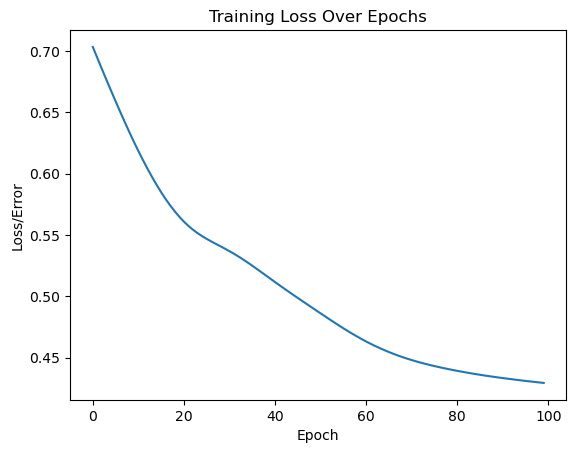

In [11]:
# Vẽ đồ thị độ mất mát qua các epochs
plt.plot(range(epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss/Error')
plt.title('Training Loss Over Epochs')
plt.show()

In [12]:
# Đánh giá mô hình trên tập dữ liệu kiểm tra (validate model on test set)
with torch.no_grad(): # Về cơ bản tắt back propagation (tắt gradient descent)

    # Dự đoán trên tập kiểm tra
    y_eval = model.forward(X_test_tensor) # X_test_tensor là các đặc trưng từ tập kiểm tra, y_eval sẽ là các dự đoán

    # Tính độ mất mát trên tập kiểm tra
    loss = loss_function(y_eval, y_test_tensor)
    
print(f'Test Loss: {loss.item():.4f}')

Test Loss: 0.4082


In [13]:
# Tính số lượng dự đoán đúng trên tập kiểm tra
correct = 0
with torch.no_grad():
    for i, data in enumerate(X_test_tensor):
        y_val = model.forward(data)
        # Đúng hay không
        if y_val.argmax().item() == y_test_tensor[i]:
            correct += 1
print(f'We got {correct} correct!')

We got 1139 correct!


In [14]:
# Chuyển mô hình sang chế độ đánh giá
model.eval()

# Dự đoán trên tập huấn luyện và tập kiểm tra bằng mô hình Neural Network
with torch.no_grad():
    train_preds_nn = model(X_train_tensor.to(device)).cpu().numpy()
    test_preds_nn = model(X_test_tensor.to(device)).cpu().numpy()

# Kết hợp đặc trưng gốc và dự đoán của mô hình Neural Network để tạo đặc trưng mới cho Random Forest
X_train_combined = np.hstack((X_train.values, train_preds_nn))
X_test_combined = np.hstack((X_test.values, test_preds_nn))

# Huấn luyện mô hình Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_combined, y_train.values)

# Dự đoán tỉ lệ rời bỏ trên tập kiểm tra bằng mô hình Random Forest Classifier
y_pred_proba = rf_model.predict_proba(X_test_combined)[:, 1]
print(f'Training Accuracy: {rf_model.score(X_train_combined, y_train.values):.4f}')

Training Accuracy: 0.9982


In [15]:
# Chuyển đổi dự đoán xác suất thành dự đoán nhị phân
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Tính toán các chỉ số đánh giá
accuracy = accuracy_score(y_test_values, y_pred_binary)
precision = precision_score(y_test_values, y_pred_binary)
recall = recall_score(y_test_values, y_pred_binary)
f1 = f1_score(y_test_values, y_pred_binary)
auc_roc = roc_auc_score(y_test_values, y_pred_binary)

In [16]:
# Tạo DataFrame lưu trữ các chỉ số đánh giá
values_df = pd.DataFrame({
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1-score': [f1],
    'AUC-ROC': [auc_roc]
})
values_df

,Accuracy,Precision,Recall,F1-score,AUC-ROC
0,0.801987,0.666667,0.504021,0.574046,0.706644


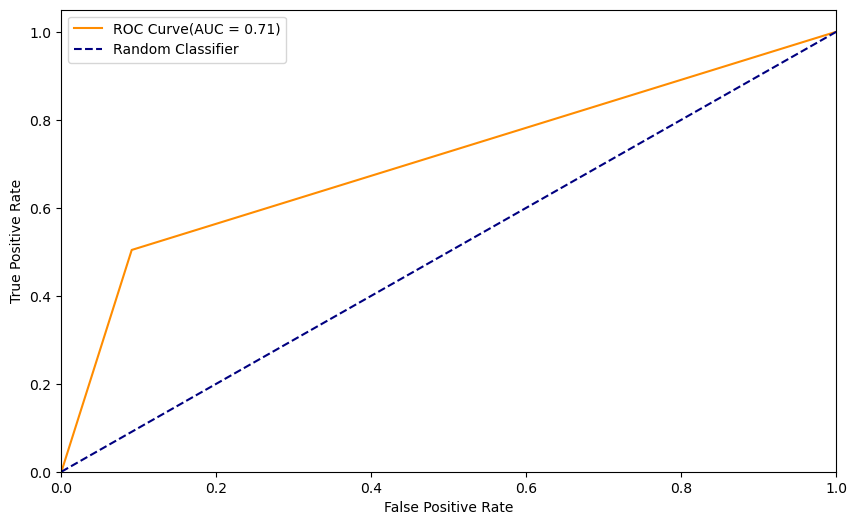

In [17]:
# Vẽ biểu đồ ROC
from sklearn.metrics import roc_curve

fpr, tpr , _ = roc_curve(y_test_values, y_pred_binary)
plt.figure(figsize = (10,6))
plt.plot(fpr, tpr, color = 'darkorange', label = f'ROC Curve(AUC = {auc_roc:.2f})')
plt.plot([0,1], [0,1], color = 'navy', linestyle = '--', label = 'Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [18]:
# Tính độ quan trọng của các đặc trưng trong mô hình Random Forest
feature_importances = rf_model.feature_importances_
feature_names = list(X_train.columns) + ['NN_Prediction_1'] + ['NN_Prediction_2']

# Tạo DataFrame để lưu trữ độ quan trọng của các đặc trưng
importance_df = pd.DataFrame({
    'Feature': feature_names, 
    'Importance': feature_importances})
importance_df = importance_df.sort_values(by = 'Importance', ascending = False)
importance_df

,Feature,Importance
24,NN_Prediction_2,0.211324
23,NN_Prediction_1,0.193204
15,TotalCharges,0.120883
14,MonthlyCharges,0.112169
4,tenure,0.106668
16,InternetService_Fiber optic,0.023052
21,PaymentMethod_Electronic check,0.019968
0,gender,0.018155
2,Partner,0.015757
19,Contract_Two year,0.015670


<Axes: title={'center': 'Feature Importance'}, xlabel='Importance', ylabel='Feature'>

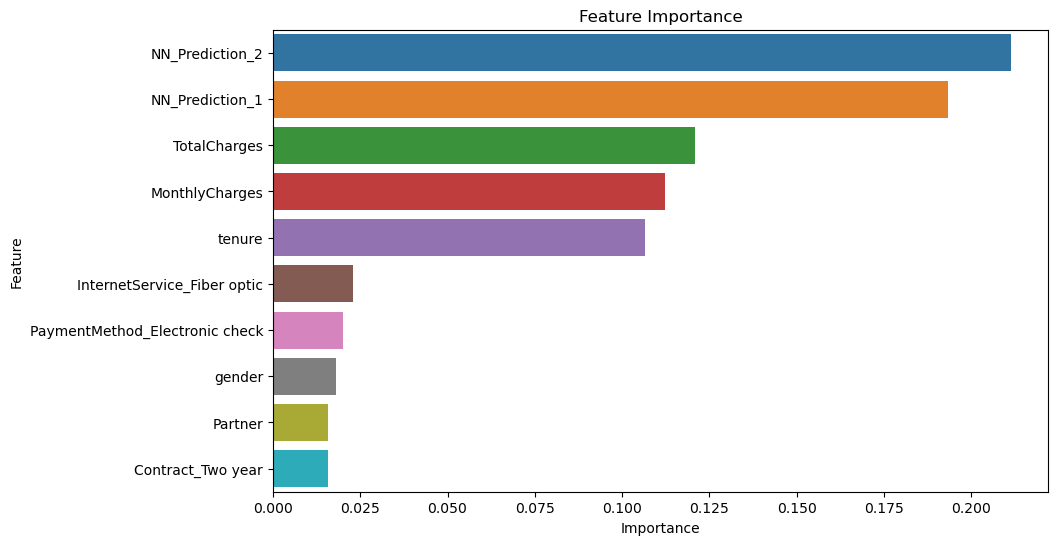

In [19]:
# Vẽ biểu đồ độ quan trọng của các đặc trưng
plt.figure(figsize = (10,6))
plt.title('Feature Importance')
sns.barplot(data = importance_df.head(10),
         x = 'Importance',
         y = 'Feature')